In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import seaborn as sns

from feos.si import *
from feos.eos import *
from feos.pcsaft import *
from feos.eos.estimator import Estimator, Loss, DataSet

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')
colors = sns.palettes.color_palette('Dark2', 5)

In [2]:
identifier = Identifier(
    cas="110-54-3", 
    name="hexane", 
    iupac_name="hexane", 
    smiles="CCCCCC", 
    inchi="InChI=1/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3", 
    formula="C6H14"
)

molarweight = 86.177 # g / mol

In [3]:
def eos_from_parameters(p):
    """Returns equation of state (PC-SAFT) for current parameters."""
    global identifier, molarweight
    m, sigma, epsilon_k = p
    model_record = PcSaftRecord(m, sigma, epsilon_k)
    pure_record = PureRecord(identifier, molarweight, model_record)
    parameters = PcSaftParameters.new_pure(pure_record)
    return EquationOfState.pcsaft(parameters)

def cost(p, estimator):
    """Calculates cost function for current parameters."""
    eos = eos_from_parameters(p)
    return estimator.cost(eos)

In [4]:
data_psat = pd.read_csv("data/hexane_vapor_pressure.csv")
dataset_psat = DataSet.vapor_pressure(
    target=data_psat["vapor_pressure / bar"].values * BAR,
    temperature=data_psat["temperature / K"].values * KELVIN,
    extrapolate=True
)

In [5]:
data_rhol = pd.read_csv("data/hexane_liquid_density.csv")
dataset_rhol = DataSet.liquid_density(
    target=data_rhol["density / kg/m3"].values * KILOGRAM / METER**3,
    temperature=data_rhol["temperature / K"].values * KELVIN,
    pressure=data_rhol["pressure / bar"].values * BAR
)

In [6]:
estimator = Estimator(
    data=[dataset_psat, dataset_rhol],
    weights=[3, 2],
    losses=[Loss.huber(0.05), Loss.huber(0.05)]
)

# Adjust parameters

In [7]:
%%time
initial_parameters = [2.0, 3.0, 200.0] # m, sigma, epsilon_k
bounds = ([2.0, 2.0, 150.0], [8.0, 5.0, 500.0]) # ([lower bounds], [upper bounds])
fitted_parameters = least_squares(cost, initial_parameters, bounds=bounds, args=(estimator,), verbose=2).x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9791e-03                                    6.57e-02    
       1              2         7.5622e-04      4.22e-03       2.14e+01       9.96e-03    
       2              3         9.9888e-05      6.56e-04       1.65e+01       1.81e-03    
       3              4         5.1211e-06      9.48e-05       9.07e-01       5.05e-05    
       4              5         3.2764e-06      1.84e-06       1.72e+00       5.99e-06    
       5              6         3.2201e-06      5.63e-08       2.30e+00       1.39e-05    
       6              7         3.2166e-06      3.47e-09       5.51e-01       3.32e-06    
       7              8         3.2164e-06      1.88e-10       1.25e-01       6.07e-07    
       8              9         3.2164e-06      7.78e-12       2.58e-02       1.01e-07    
       9             10         3.2164e-06      3.12e-13       5.34e-03       1.57e-08    

In [8]:
print("Adjusted parameters")
print("m         = {:>8.4}".format(fitted_parameters[0]))
print("sigma     = {:>8.4} A".format(fitted_parameters[1]))
print("epsilon_k = {:>8.6} K".format(fitted_parameters[2]))
print("")

mard = estimator.mean_absolute_relative_difference(eos_from_parameters(fitted_parameters)) * 100
print("MARD (including outliers)")
print("p_sat = {:<4.2} %".format(mard[0]))
print("rho_l = {:<4.2} %".format(mard[1]))

Adjusted parameters
m         =    3.024
sigma     =    3.811 A
epsilon_k =  238.333 K

MARD (including outliers)
p_sat = 6.3  %
rho_l = 0.93 %


# Plot resuts

In [9]:
phase_diagram = PhaseDiagram.pure(eos_from_parameters(fitted_parameters), 250.0 * KELVIN, 201)

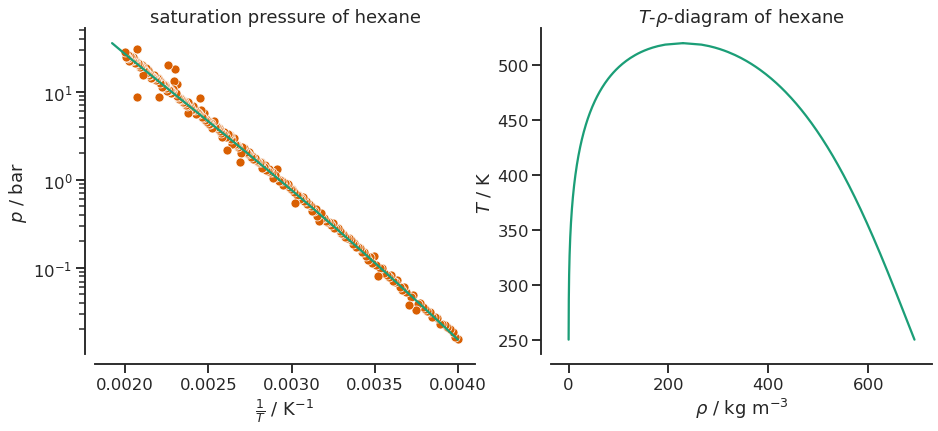

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].set_title("saturation pressure of hexane")

sns.lineplot(
    y=phase_diagram.vapor.pressure / BAR,
    x=1.0/phase_diagram.vapor.temperature * KELVIN,
    ax=ax[0]
)
sns.scatterplot(
    x=1.0 / data_psat["temperature / K"], 
    y=data_psat["vapor_pressure / bar"], 
    ax=ax[0],
    color=colors[1]
)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$\frac{1}{T}$ / K$^{-1}$');
ax[0].set_ylabel(r'$p$ / bar');
#ax[0].set_xlim()
#ax[0].set_ylim()

ax[1].set_title(r"$T$-$\rho$-diagram of hexane")
sns.lineplot(
    y=phase_diagram.vapor.temperature / KELVIN,
    x=phase_diagram.vapor.mass_density / KILOGRAM * METER**3,
    ax=ax[1],
    color=colors[0]
)
sns.lineplot(
    y=phase_diagram.liquid.temperature / KELVIN,
    x=phase_diagram.liquid.mass_density / KILOGRAM * METER**3,
    ax=ax[1],
    color=colors[0]
)

ax[1].set_ylabel(r'$T$ / K');
ax[1].set_xlabel(r'$\rho$ / kg m$^{-3}$');

sns.despine(offset=10)